# Розробока нейронної мережі без використання бібліотек

Цей проєкт створено для поглибленного ознайомлення із алгоритмом роботи нейронних мереж. Для розробки використовуються суто структури даних Python та Numpy (бібліотека з функціями для лінійної алгебри).

In [380]:
import random
import numpy as np
from micrograd.engine import Value 

In [381]:
def createValue(x):
    return x if type(x) == Value else Value(x)
        

In [382]:
print(createValue(1))
print(createValue(Value(1)))

Value(data=1, grad=0)
Value(data=1, grad=0)


## Функція активації

Функція активації використовується для використання __нелінійності__ при побудові функції класифікації (або регресії).

Найбільш поширеними функціями активації є:
- Sigmoid
- Tanh
- RelU
- LeakyRelU

Для даної нейронної мережі буде використана функція RelU:

RelU = max(0, x)

## RelU

Функція активації RelU може бути використана з бібліотеки micrograd для легкого обчислення похідної складної функції

RelU = `max(0, x)`

## Нейрон

Виступає атомарним будівельник блоком нейронної мережі

In [383]:
class Neuron:
    def __init__(self, inputs, weights, bias):
        self.inputs = list(map(lambda i: createValue(i), inputs))
        self.weights = list(map(lambda w: createValue(w), weights))
        self.bias = createValue(bias)
        self.value = None
        
    def output(self):
        result = createValue(0)
        for input, weight in zip(self.inputs, self.weights):
            result += input * weight
        result += self.bias
        return result
    
    def set_inputs(self, inputs):
        # TODO akicha: використання функціональності через композицію обʼєкту
        self.inputs = list(map(lambda i: createValue(i), inputs))
        
    def forward(self):
        # функція активації імпортована з мікроград бібліотеки для правильного прорахунку
        # похідної складної функції під час зворотньої пропагації
        self.value = NeuralNetwork.activation(self.output())
    
    def backward(self):
        # На момент виконання, .backward обовʼязкового повинен бути виконаний на функції втрат (loss)
        for idx, weight in self.weights:
            dLdwidx = self.weights[idx].grad
            self.weights[idx] -= NeuralNetwork.learning_rate * dLdwidx
                
        dLdb = self.bias.grad
        self.bias -= NeuralNetwork.learning_rate * dLdb

In [384]:
class InputNeuron:
    def __init__(self, v):
        self.value = createValue(v)
    
    # noop
    def forward():
        pass
    
    # noop
    def backward():
        pass

In [385]:
class Layer:
    def __init__(self, prevLayer, numNeurons):
        self.neurons = []
        self.prevLayer = prevLayer;
        inputs = prevLayer.values();
        for neuron in range(numNeurons):
            # при ініціалізації ми не знаємо правильних значень ваги тому ініціалізуємо випадково
            # пізніше, нейронна мережа сама знайде правильні значення
            weights = np.random.randn((len(inputs)))
            # при ініціалізації ми не знаємо правильного значення байесу
            # пізніше, нейронна мережа сама знайде правильне значення
            bias = np.random.randn()
            self.neurons.append(Neuron(inputs, weights, bias))
        
    def forward(self):
        inputs = self.prevLayer.values();
        
        for neuron in self.neurons:
            neuron.set_inputs(inputs)
            neuron.forward()
    
    def backward(self):
        for neuron in self.neurons:
            neuron.backward()
            
    # TODO akicha: використання методу через композицію обʼєктів
    def values(self):
        return list(map(lambda n: n.value, self.neurons))

In [386]:
class InputLayer:
    def __init__(self, inputs):
        self.neurons = []
        for i in range(len(inputs)):
            self.neurons.append(InputNeuron(inputs[i]))
    
    # дані нейрони можна і потрібно перезаписувати так як кожен нейрон - це характеристика обʼєкту
    # що змінюється із кожною ітерацією
    def set_inputs(self, inputs):
        self.neurons = []
        for i in range(len(inputs)):
            self.neurons.append(InputNeuron(inputs[i]))
    
    # noop
    def forward(self):
        pass
    
    # noop
    def backward(self):
        pass
            
    def values(self):
        return list(map(lambda n: n.value, self.neurons))

## Нейронна мережа

In [393]:
# TODO akicha: перемістити дані в окремий клас
loss_plot_x = []
loss_plot_y = []

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
    
    @staticmethod
    def activation(x):
        return x.relu()
        
    # y - очікуєме значення
    # y_hat - спрогнозоване значення
    def loss(self, y):
        outputLayer = self.layers[-1]
        # N = 1 так як тільки один нейрон присутній в останньому шарі нейронної мережі
        N = len(outputLayer.values())
        # на даний момент в нейронній мережі є лише один нейрон у останньому шарі нейронної мережі
        y_hat = self.prediction()
        return createValue(1) / createValue(N) * (createValue(y) - y_hat)**2
    
    def forward(self):
        for layer in self.layers:
            layer.forward()
            
    def backward(self):
        for layer in range(len(self.layers)):
            layer = self.layers[-idx - 1]
            layer.backward()
            
    def prediction(self):
        outputLayer = self.layers[-1]
        return outputLayer.values()[0]
    
    # TODO akicha: create new class from data
    def gradient(self, epochs, data):
        steps = 0
        for e in range(epochs):
            print(f'start epoch {e}')
            
            # TODO akicha: нейронна мережа знає багато про форму вхідних даних
            # потрібно виділити дані в окремий клас для генералізації класу NeuralNetwork
            for data_sample in data:
                expected_value = data_sample[2]
                # шар вхідних даних
                self.layers[0].set_inputs([data_sample[0], data_sample[1]])
            
                #логування початкових значень нейронів у кожному з шарів
                #for idx, layer in self.layers:
                #    print(idx)
                #    print(self.layers[idx].values(), f'the values {idx} before forward')

                self.forward()

                # логування значень після forward кроку нейронів у кожному з шарів
                #for idx, layer in self.layers:
                #    print(self.layers[idx].values(), f'the values {idx} after forward')

                y_hat = self.prediction()
                print(y_hat.data, 'the prediction')

                loss = self.loss(expected_value)

                # micrograd
                loss.backward()
                
                self.backward()
                
                steps += 1
                
                loss_plot_x.append(steps)
                loss_plot_y.append(loss.data)
    
    learning_rate = 0.7

## Набір даних

In [388]:
# [length, width, class]
entities_class_1 = [
    [3, 1, 1],
    [2, 2, 1],
    [1.5, 2.5, 1]
]

entities_class_2 = [
    [1, 3, 0]
]

# набір даних для тестування
entities = entities_class_1 + entities_class_2

# набір даних для тесту
entity_secret = [1.75, 2.25]

## Пісочниця для тестування проміжного результату роботи

In [418]:
inputLayer = InputLayer([])
hiddenLayer = Layer(inputLayer, 2)
outputLayer = Layer(hiddenLayer, 1)
nn = NeuralNetwork([inputLayer, hiddenLayer, outputLayer])

entity = [3, 1, 1]

expected = entity[2]
print(expected)
print('\n')
inputLayer.set_inputs([entity[0], entity[1]])

print(inputLayer.values())
inputLayer.forward()
print('\n')

print(hiddenLayer.values())
hiddenLayer.forward()
print(hiddenLayer.values())
print('\n')

print(outputLayer.values())
outputLayer.forward()
print(outputLayer.values())
print('\n')

y_hat = outputLayer.values()[0]
print(y_hat)
print(nn.prediction())
loss = nn.loss(expected)
print('\n')

loss.backward()

print(inputLayer.values())
print(hiddenLayer.values())
print(outputLayer.values())
print('\n')

nn.backward()

inputLayer.forward()
hiddenLayer.forward()
outputLayer.forward()

print(inputLayer.values())
print(hiddenLayer.values())
print(outputLayer.values())

1


[Value(data=3, grad=0), Value(data=1, grad=0)]


[None, None]
[Value(data=1.4740686727053411, grad=0), Value(data=0.7104833222699426, grad=0)]


[None]
[Value(data=0.4905592841776979, grad=0)]


Value(data=0.4905592841776979, grad=0)
Value(data=0.4905592841776979, grad=0)


[Value(data=3, grad=0), Value(data=1, grad=0)]
[Value(data=1.4740686727053411, grad=-0.07426194097042862), Value(data=0.7104833222699426, grad=-0.12623302571433173)]
[Value(data=0.4905592841776979, grad=-1.0188814316446042)]


[Value(data=3, grad=0), Value(data=1, grad=0)]
[Value(data=1.4740686727053411, grad=0), Value(data=0.7104833222699426, grad=0)]
[Value(data=0.4905592841776979, grad=0)]


In [394]:
inputLayer = InputLayer([])
hiddenLayer = Layer(inputLayer, 2)
outputLayer = Layer(hiddenLayer, 1)
n = NeuralNetwork([inputLayer, hiddenLayer, outputLayer])

n.gradient(10, entities)

start epoch 0
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 1
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 2
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 3
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 4
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 5
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 6
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 7
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 8
0 the prediction
0 the prediction
0 the prediction
0 the prediction
start epoch 9
0 the prediction
0 the prediction
0 the prediction
0 the prediction


## Графік залежності функції втрат від кількості кроків тренування моделі

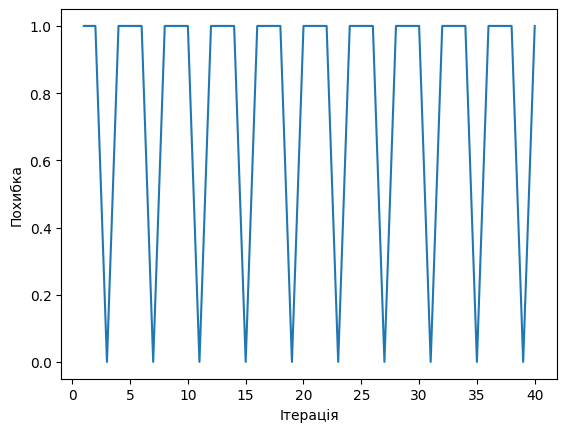

In [390]:
plt.plot(loss_plot_x, loss_plot_y)

plt.xlabel('Ітерація')
plt.ylabel('Похибка')

plt.show()

## Візуалізація набору даних

import matplotlib.pyplot as plt

x = list(map(lambda e: e[0], entities_class_1))
y = list(map(lambda e: e[1], entities_class_1))

x2 = list(map(lambda e: e[0], entities_class_2))
y2 = list(map(lambda e: e[1], entities_class_2))

plt.scatter(x, y)
plt.scatter(x2, y2)
plt.scatter(entity_secret[0], entity_secret[1])


plt.legend(['тип 1', 'тип 2', 'невідомий тип'])

plt.show()

## Тренування моделі

### Ініціалізація

neuron = Neuron([], [0.2, 0.7], 0)

plot_data = []

for i in range(1, 300):
    random_entity = random.choice(entities)
    
    neuron.set_inputs([random_entity[0], random_entity[1]])

    # print(f'Random entity is of type: {random_entity[2]}')

    # print(f'Iteration number: {i}')

    output = neuron.forward()
    # print(f'Predicted type is: {output}')
    
    loss = neuron.loss(random_entity[2], output)
    if (i % 10 == 0):
        print(f'Calculated Loss: {loss}')

    
    neuron.backward(random_entity[2], output)
    
    plot_data.append([i, loss])